In [1]:
import pandas as pd
crypto_df=pd.read_csv("crypto_data.csv")
crypto_df

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...,...
1247,XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
1248,DVTC,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
1249,GIOT,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
1250,OPSC,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


In [2]:
#discard all cryptocurrency that are not being traded,ie filter for currencies that are currently being traded
trading = crypto_df.loc[crypto_df["IsTrading"]==True]
trading["IsTrading"].value_counts()

True    1144
Name: IsTrading, dtype: int64

In [3]:
crypto_trading = trading.drop("IsTrading", axis=1)
crypto_trading.head()

,Unnamed: 0,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,PoW,NaN,611000
4,808,808,SHA-256,PoW/PoS,0.000000e+00,0


In [4]:
#remove rows with at least one null value
crypto_full= crypto_trading.dropna(how = 'any')
crypto_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 0 to 1247
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       685 non-null    object 
 1   CoinName         685 non-null    object 
 2   Algorithm        685 non-null    object 
 3   ProofType        685 non-null    object 
 4   TotalCoinsMined  685 non-null    float64
 5   TotalCoinSupply  685 non-null    object 
dtypes: float64(1), object(5)
memory usage: 37.5+ KB


In [5]:
#filter for crypto that have been mined
crypto_mined = crypto_full.loc[crypto_full["TotalCoinsMined"] >0 ]
crypto_mined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 0 to 1247
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       532 non-null    object 
 1   CoinName         532 non-null    object 
 2   Algorithm        532 non-null    object 
 3   ProofType        532 non-null    object 
 4   TotalCoinsMined  532 non-null    float64
 5   TotalCoinSupply  532 non-null    object 
dtypes: float64(1), object(5)
memory usage: 29.1+ KB


In [9]:
#Remove coin names not numeric and does not contribute to analysis 
crypto_ml = crypto_mined.drop("CoinName", axis=1)
crypto_ml = crypto_ml.drop('Unnamed: 0', axis =1)

In [10]:
#convert remaining features with text values
crypto_ml = pd.get_dummies(data = crypto_ml, columns = ['Algorithm', 'ProofType'])
crypto_ml.shape

(532, 98)

In [11]:
#Standardize dataset 
from sklearn.preprocessing import StandardScaler
crypto_scaled = StandardScaler().fit_transform (crypto_ml)
crypto_scaled

array([[-0.11710817, -0.1528703 , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.09396955, -0.145009  , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [ 0.52494561,  4.48942416, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       ...,
       [-0.09561336, -0.13217937, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11694817, -0.15255998, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11710536, -0.15285552, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ]])

In [13]:
#dimensionality Reduction with PCA with an **expalined variance**, preserve 90% 
from sklearn.decomposition import PCA
pca = PCA(n_components=.9)
components = pca.fit_transform(crypto_scaled)
components.shape

(532, 74)

In [14]:
#additional dimenstionality reduction using t-SNE, on the principal components , the output of the PCA transformation
from sklearn.manifold import TSNE
X_embedded = TSNE().fit_transform(components)
X_embedded.shape

(532, 2)

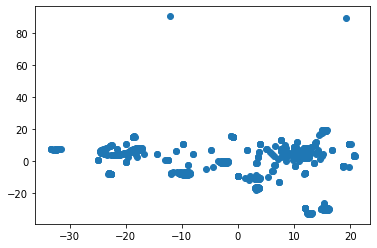

In [17]:
#create scatterplot of tSNE output
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded [:,1])
plt.show()

C:\Users\cblac\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


<AxesSubplot:xlabel='k'>

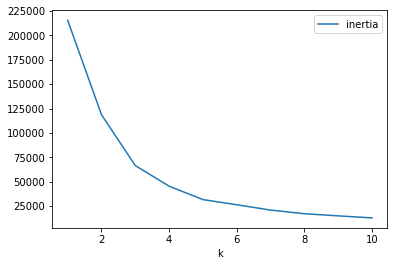

In [20]:
from sklearn.cluster import KMeans
#cluster analysis with K-means create an elbow plot 
inertia = []
k= list(range(1, 11))

#calculate the inertia lfor the range of k values
for i in k:
    km=KMeans(n_clusters = i, random_state = 0)
    km.fit(X_embedded)
    inertia.append(km.inertia_)
    
#create the elbow curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
crypto_elbow = pd.DataFrame(elbow_data)
crypto_elbow.plot (x='k', y='inertia')

After removal of non traded cryptocurrencies and filtering the data set for currency that have not been mined the 
resulting data set was analyzed.  Based on the resulting elbow plot the 532 remaining crytocurrencies could be clustered
into 3 clusters, based on the bend in the data.   